In [1]:
import pandas
import numpy
from matplotlib import pyplot as plt
from toposample.data.data_structures import ConditionCollection

%matplotlib inline

gini_thresh = 0.25

fn = "/home/reimann/Documents/data/THNCX/M7_validation/compared_densities_VIP_SST_PV_FIX.pkl"
data = pandas.read_pickle(fn)
display(data)
cc = ConditionCollection.from_pandas(data["Density"])

layers = sorted(cc.labels_of("Layer"))
mtypes = sorted(cc.labels_of("Mtype"))
regions = sorted(cc.labels_of("Region"))

,,,Density,Volume,Max to median,Max to 99
Mtype,Layer,Region,,,,
densities_SST,1,ACAd,1146.935593,595828125.0,1.000000,1.000000
densities_REST,1,ACAd,17404.396197,595828125.0,1.000000,1.000000
densities_GAD,1,ACAd,21577.168694,595828125.0,14539.841539,4159.108831
densities_VIP,1,ACAd,2525.151524,595828125.0,5.933787,1.289071
densities_PV,1,ACAd,500.685380,595828125.0,1.000000,1.000000
...,...,...,...,...,...,...
densities_REST,6,VISrl,8195.092824,180046875.0,1.000000,1.000000
densities_GAD,6,VISrl,21172.383454,180046875.0,1.000000,1.000000
densities_VIP,6,VISrl,521.861959,180046875.0,2.180162,1.000000


In [2]:
def distribution_gini(vals):
    vals = [_x for _x in vals if not numpy.isnan(_x)]
    if len(vals) == 0:
        return numpy.NaN
    vals = numpy.cumsum(sorted(vals)) / numpy.sum(vals)
    return (0.5 - numpy.trapz(vals, dx=1./len(vals))) / 0.5

def filter_layer(layers, mtypes, regions, values):
    for l, m, r, v in zip(layers, mtypes, regions, values):
        if "_" in m:
            splt = m.split("_")[0]
            if l not in splt:
                v = numpy.NaN
        yield v, {"Layer": l, "Mtype": m, "Region": r}

def ordered_stack(x, y):
    idxx = numpy.argsort(x)
    return [y[i] for i in idxx]

def outliers(x, y):
    y = numpy.array(y)
    mn = numpy.nanmean(y)
    rel_y = (y - mn) / (y + mn)
    return [(_x, _y) for _x, _y in zip(x, rel_y) if numpy.abs(_y) > 0.66]

using_individual_mtypes = False
if using_individual_mtypes:
    cc_fltr = cc.transform(["Layer", "Mtype", "Region"], func=filter_layer, xy=True)
else:
    cc_fltr = cc
dens_vecs = cc_fltr.pool(["Region"], func=ordered_stack, xy=True)
dens_outliers = cc_fltr.pool(["Region"], func=outliers, xy=True)
gini = dens_vecs.map(distribution_gini)
gini_img = gini.pool(["Layer"],
                          func=ordered_stack,
                          xy=True).pool(["Mtype"],
                                        func=ordered_stack,
                                        xy=True).map(numpy.array)


<ipython-input-2-502a3795898b>:22: RuntimeWarning: Mean of empty slice
  mn = numpy.nanmean(y)


Text(0.5, 1.0, '(normalized) gini coefficient of densities over regions')

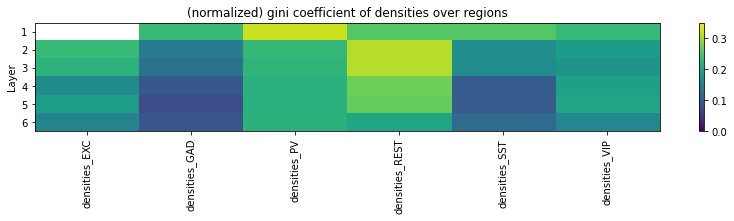

In [3]:
ax = plt.figure(figsize=(14, 2)).gca()
img = ax.imshow(gini_img.get2().transpose(), aspect='auto')
img.set_clim([0, 0.35])
plt.colorbar(img)

ax.set_xticks(range(len(mtypes)))
ax.set_xticklabels(mtypes, rotation='vertical')
ax.set_yticks(range(len(layers)))
ax.set_yticklabels(layers)
ax.set_ylabel("Layer")
ax.set_title("(normalized) gini coefficient of densities over regions")

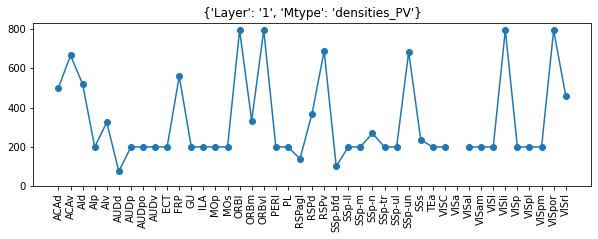

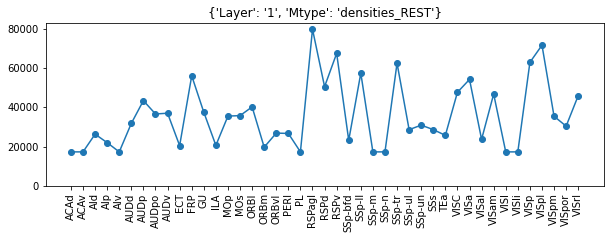

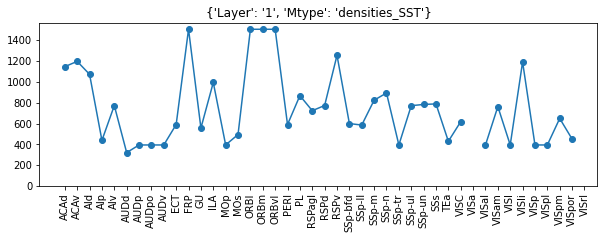

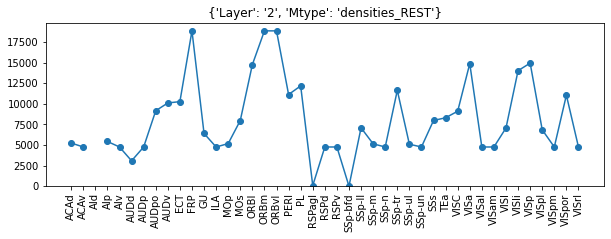

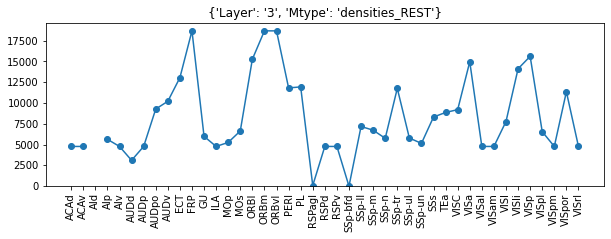

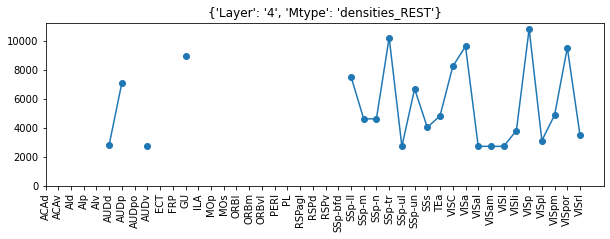

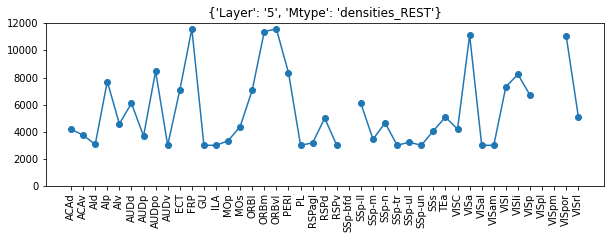

In [5]:
exceeds = [x.cond for x in gini.contents if x.res > gini_thresh]

for conds in exceeds:
    ax = plt.figure(figsize=(10, 3)).gca()
    D = dens_vecs.get2(**conds)
    #D = 100 * numpy.array(D) / numpy.nansum(D)
    ax.plot(D, marker='o', label=str(conds))
#plt.legend()
    ax.set_xticks(range(len(regions)))
    ax.set_title(str(conds))
    _ = ax.set_xticklabels(regions, rotation="vertical")
    ax.set_ylim([0, ax.get_ylim()[1]])

In [6]:
for x in dens_outliers.contents:
    if len(x.res) > 0:
        print("layer {0}, mtype {1}:\n".format(x.cond["Layer"], x.cond["Mtype"]))
        for entry in x.res:
            print("\tregion {0}: {1}".format(*entry))
        

layer 2, mtype densities_REST:

	region RSPagl: -0.982204138505606
	region SSp-bfd: -0.9999985140581602
layer 3, mtype densities_REST:

	region RSPagl: -0.9807286507409929
	region SSp-bfd: -0.9999983520583681


In [7]:
def lst_amount_of_outlying(lst_region_dict):
    out_dict = {}
    for reg_dict in lst_region_dict:
        for k, v in reg_dict:
            out_dict.setdefault(k, []).append(v)
    return out_dict

pool_also_mtype = True
if pool_also_mtype:
    total_outlying = dens_outliers.pool(["Layer", "Mtype"], func=lst_amount_of_outlying)
    total_outlying.add_label("Mtype", "All types")
else:
    total_outlying = dens_outliers.pool(["Layer"], func=lst_amount_of_outlying)

num_outlying = total_outlying.map(lambda x: dict([(k, len(v)) for k, v in x.items()]))

print(num_outlying.to_pandas())

Mtype    
All types    {'RSPagl': 2, 'SSp-bfd': 2}
dtype: object


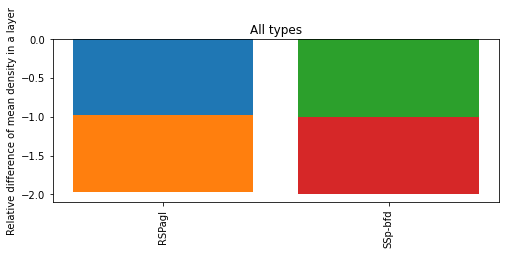

In [8]:
for mtype in total_outlying.labels_of("Mtype"):
    plt_dict = total_outlying.get2(Mtype=mtype)
    region, n = zip(*num_outlying.get2(Mtype=mtype).items())
    idxx = numpy.argsort(list(n))
    ax = plt.figure(figsize=(8, 3)).gca()
    for i, idx in enumerate(idxx):
        vs = plt_dict[region[idx]]
        o_pos = 0
        o_neg = 0
        for v in vs:
            if v < 0:
                ax.bar(i, v,  bottom=o_neg)
                o_neg += v
            else:
                ax.bar(i, v, bottom=o_pos)
                o_pos += v
    ax.set_xticks(range(len(region)))
    ax.set_xticklabels([region[idx] for idx in idxx], rotation='vertical')
    ax.set_title(mtype)
    ax.set_ylabel("Relative difference of mean density in a layer")

In [15]:
outlying = data[["Max to median", "Max to 99"]].loc[data["Max to 99"] > 100]

for idx, vals in outlying.iterrows():
    print("""
    In layer {0} of {1} of {2}
        the maximal density is a whooping {3} times above the median
        and {4} times above the 99th percentile!
    """.format(idx[1], idx[2], idx[0], vals["Max to median"], vals["Max to 99"]))


    In layer 1 of ACAd of densities_GAD
        the maximal density is a whooping 14539.841538625762 times above the median
        and 4159.108830616754 times above the 99th percentile!
    


In [14]:
outlying = data[["Max to median", "Max to 99"]].loc[data["Max to 99"] > 100]
for idx, vals in outlying.iterrows():
    print(idx)

('densities_GAD', '1', 'ACAd')
